<a href="https://colab.research.google.com/github/emicervantes/wound_classification/blob/main/u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Wound Classification with U-Net

In [ ]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

### Load wound data

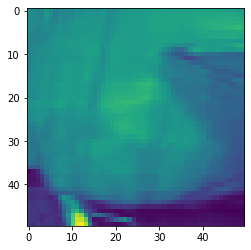

In [ ]:
X = np.load('wound_features.npy', encoding = 'bytes')
Y = np.load('wound_label.npy', encoding = 'bytes')
XTr, XTe, YTr, YTe = train_test_split(X,Y,test_size = 0.30)

plt.imshow(XTr[3,:,:,0])

In [ ]:
batch_size = 100

torch_XTr = torch.tensor(XTr)
torch_YTr = torch.tensor(YTr)
torch_XTe = torch.tensor(XTe)
torch_YTe = torch.tensor(YTe)

train = torch.utils.data.TensorDataset(torch_XTr, torch_YTr)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)

test = torch.utils.data.TensorDataset(torch_XTe, torch_YTe)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [ ]:
X, Y = next(iter(train_loader))
print(X.shape, Y.shape)

torch.Size([100, 50, 50, 3]) torch.Size([100])


In [ ]:
X = torch.swapaxes(X, 1, 3)

### U-Net Implementation

In [ ]:
class UNET(nn.Module):
  def encoder(self, in_channels, out_channels, kernel_size = 2):
    block = torch.nn.Sequential(
              torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = out_channels),
              torch.nn.ReLU(),
              torch.nn.BatchNorm2d(out_channels),
              torch.nn.Conv2d(kernel_size = kernel_size, in_channels = out_channels, out_channels = out_channels),
              torch.nn.ReLU(),
              torch.nn.BatchNorm2d(out_channels),
    )
    return block

  def decoder(self, in_channels, mid_channel, out_channels, kernel_size = 2):
    block = torch.nn.Sequential(
        torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = mid_channel),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(mid_channel),
        torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channel, out_channels = mid_channel),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(mid_channel),
        torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels = out_channels, kernel_size = 2, stride = 2, padding = 1, output_padding = 1)
    )
    return block

  def final_block(self, in_channels, mid_channel, out_channels, kernel_size = 2):
    block = torch.nn.Sequential(
        torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = mid_channel),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(mid_channel),
        torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channel, out_channels = mid_channel),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(mid_channel),
        torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channel, out_channels = out_channels, padding = 1),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(out_channels),
    )
    return block

  def __init__(self, in_channel, out_channel):
    super(UNET, self).__init__()
    self.conv_encode1 = self.encoder(in_channels = in_channel, out_channels =64)
    self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size = 2)
    self.conv_encode2 = self.encoder(64,128)
    self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size = 2)
    self.conv_encode3 = self.encoder(128,256)
    self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size = 2)

    self.bottleneck = torch.nn.Sequential(
        torch.nn.Conv2d(kernel_size = 2, in_channels = 256, out_channels = 512),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(512),
        torch.nn.Conv2d(kernel_size = 2, in_channels =512, out_channels = 512),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(512),
        torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2, padding = 1, output_padding = 1)
    )

    self.conv_decode3 = self.decoder(512, 256, 128)
    self.conv_decode2 = self.decoder(256, 128, 64)
    self.final_layer = self.final_block(128, 64, out_channel)

  def crop_and_concat(self, upsampled, bypass, crop = False):
    if crop:
      c = (bypass.size()[2] - upsampled.size()[2]) // 2
      bypass = TF.pad(bypass, (-c, -c, -c, -c))
    return torch.cat((upsampled, bypass), 1)

  def forward(self, x):
    encode_block1 = self.conv_encode1(x)
    encode_pool1 = self.conv_maxpool1(encode_block1)
    encode_block2 = self.conv_encode2(encode_pool1)
    encode_pool2 = self.conv_maxpool2(encode_block2)
    encode_block3 = self.conv_encode3(encode_pool2)
    encode_pool3 = self.conv_maxpool3(encode_block3)
    
    bottleneck1 = self.bottleneck(encode_pool3)

    decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop = True)
    cat_layer2 = self.conv_decode3(decode_block3)
    decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop = True)
    cat_layer1 = self.conv_decode3(decode_block2)
    decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop = True)
    final_layer = self.conv_decode3(decode_block1)
    
    return final_layer      

In [ ]:
unet = UNET(in_channel=3,out_channel=2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)
optimizer.zero_grad()       
outputs = unet(X.float())

RuntimeError: ignored